Class: machinery, Bounding Box: (0, 48, 153, 300)
Class: Person, Bounding Box: (14, 21, 53, 128)
Class: NO-Mask, Bounding Box: (469, 277, 480, 288)
Class: NO-Hardhat, Bounding Box: (465, 253, 481, 266)
Class: Person, Bounding Box: (449, 250, 520, 300)
Class: Safety Vest, Bounding Box: (320, 300, 425, 462)
Class: Person, Bounding Box: (301, 300, 484, 640)


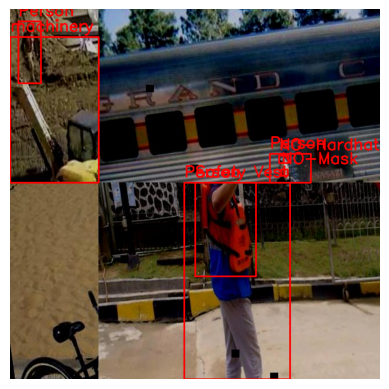

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
# 数据集路径
train_image_dir = "css-data/train/images"
train_label_dir = "css-data/train/labels"
# 类别名称
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
# 加载一张图像和对应的标注
image_name = "2_jpg.rf.2a2cafa3fd6db594c2f3a46f971b1c14.jpg"
image_path = os.path.join(train_image_dir, image_name)
label_path = os.path.join(train_label_dir, image_name.replace(".jpg", ".txt"))
# 读取图像
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape  # 获取图像的尺寸
# 读取标注
with open(label_path, "r") as f:
    labels = f.readlines()
# 绘制边界框
for label in labels:
    class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())
    
    # 将归一化坐标转换为绝对坐标
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height
    
    # 计算边界框的左上角和右下角坐标
    x_min = int(x_center - box_width / 2)
    y_min = int(y_center - box_height / 2)
    x_max = int(x_center + box_width / 2)
    y_max = int(y_center + box_height / 2)
    
    # 获取类别名称
    class_name = class_names[int(class_id)]
    
    # 绘制边界框
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # 蓝色边界框，线宽为2
    
    # 在边界框上方绘制类别名称
    cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # 打印类别和边界框信息
    print(f"Class: {class_name}, Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max})")

# 显示图像
plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [5]:
import os
import shutil
from tqdm import tqdm  # 导入 tqdm 库

# 原始数据集路径
original_train_image_dir = "css-data/train/images"
original_train_label_dir = "css-data/train/labels"
original_valid_image_dir = "css-data/valid/images"
original_valid_label_dir = "css-data/valid/labels"
original_test_image_dir = "css-data/test/images"
original_test_label_dir = "css-data/test/labels"

# 新数据集路径
new_dataset_dir = "hardhat_dataset"
new_train_image_dir = os.path.join(new_dataset_dir, "train/images")
new_train_label_dir = os.path.join(new_dataset_dir, "train/labels")
new_valid_image_dir = os.path.join(new_dataset_dir, "valid/images")
new_valid_label_dir = os.path.join(new_dataset_dir, "valid/labels")
new_test_image_dir = os.path.join(new_dataset_dir, "test/images")
new_test_label_dir = os.path.join(new_dataset_dir, "test/labels")

# 创建新数据集文件夹
os.makedirs(new_train_image_dir, exist_ok=True)
os.makedirs(new_train_label_dir, exist_ok=True)
os.makedirs(new_valid_image_dir, exist_ok=True)
os.makedirs(new_valid_label_dir, exist_ok=True)
os.makedirs(new_test_image_dir, exist_ok=True)
os.makedirs(new_test_label_dir, exist_ok=True)

# 类别名称和对应的 class_id
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
target_classes = ['Hardhat', 'NO-Hardhat']
target_class_ids = [class_names.index(cls) for cls in target_classes]

def filter_and_copy_dataset(original_image_dir, original_label_dir, new_image_dir, new_label_dir, dataset_name):
    """
    过滤并复制数据集，并清理标注文件
    """
    # 获取图像文件列表
    image_files = [f for f in os.listdir(original_image_dir) if f.endswith(".jpg")]
    
    # 初始化进度条
    with tqdm(total=len(image_files), desc=f"处理 {dataset_name} 数据集") as pbar:
        for image_name in image_files:
            # 图像和标注文件路径
            image_path = os.path.join(original_image_dir, image_name)
            label_path = os.path.join(original_label_dir, image_name.replace(".jpg", ".txt"))

            # 检查标注文件是否存在
            if not os.path.exists(label_path):
                pbar.update(1)  # 更新进度条
                continue

            # 读取标注文件
            with open(label_path, "r") as f:
                labels = f.readlines()

            # 过滤出目标类别的标注
            filtered_labels = []
            for label in labels:
                class_id = int(label.split()[0])
                if class_id in target_class_ids:
                    filtered_labels.append(label)

            # 如果没有目标类别的标注，跳过该图像
            if not filtered_labels:
                pbar.update(1)  # 更新进度条
                continue

            # 保存图像到新数据集
            shutil.copy(image_path, os.path.join(new_image_dir, image_name))

            # 保存过滤后的标注文件到新数据集
            with open(os.path.join(new_label_dir, image_name.replace(".jpg", ".txt")), "w") as f:
                f.writelines(filtered_labels)

            pbar.update(1)  # 更新进度条

# 处理训练集
filter_and_copy_dataset(original_train_image_dir, original_train_label_dir, new_train_image_dir, new_train_label_dir, "训练集")

# 处理验证集
filter_and_copy_dataset(original_valid_image_dir, original_valid_label_dir, new_valid_image_dir, new_valid_label_dir, "验证集")

# 处理测试集
filter_and_copy_dataset(original_test_image_dir, original_test_label_dir, new_test_image_dir, new_test_label_dir, "测试集")

# 生成 dataset.yaml
yaml_content = f"""
path: {os.path.abspath(new_dataset_dir)}
train: train/images
val: valid/images
test: test/images

nc: {len(target_classes)}
names: {target_classes}
"""

with open(os.path.join(new_dataset_dir, "dataset.yaml"), "w") as f:
    f.write(yaml_content)

print(f"\n新数据集已保存到: {new_dataset_dir}")
print(f"dataset.yaml 已生成")

处理 测试集 数据集: 100%|██████████| 82/82 [00:00<00:00, 1504.24it/s]


新数据集已保存到: hardhat_dataset
dataset.yaml 已生成


In [6]:
import os

# 新数据集路径
new_train_label_dir = "hardhat_dataset/train/labels"
new_valid_label_dir = "hardhat_dataset/valid/labels"
new_test_label_dir = "hardhat_dataset/test/labels"

# 类别 ID 映射
class_id_mapping = {0: 0, 2: 1}  # 将 2 映射为 1

def update_label_ids(label_dir):
    """
    更新标注文件中的类别 ID
    """
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        # 更新类别 ID
        updated_lines = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id in class_id_mapping:
                parts[0] = str(class_id_mapping[class_id])
                updated_lines.append(" ".join(parts) + "\n")

        # 保存更新后的标注文件
        with open(label_path, "w") as f:
            f.writelines(updated_lines)

# 更新训练集标注文件
update_label_ids(new_train_label_dir)

# 更新验证集标注文件
update_label_ids(new_valid_label_dir)

# 更新测试集标注文件
update_label_ids(new_test_label_dir)

print("标注文件中的类别 ID 已更新")

标注文件中的类别 ID 已更新


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

def main():
    # 初始化模型
    model = YOLO('yolov8n.pt')  # 创建一个新的YOLOv8n模型
    
    # 开始训练
    model.train(
        data='hardhat_dataset/dataset.yaml',
        epochs=10,
        imgsz=256,
        batch=16,
        workers=8,
        device='0',  # 使用第一个GPU
        patience=5,  # 早停策略
        project='hardhat_results',  # 结果保存目录
        name='exp1',  # 实验名称
        save=True,  # 保存模型
        plots=True,  # 保存训练图
        val=True,  # 启用验证
        split=0.8  # 训练集占比0.8，验证集占比0.2
    )
    
    
    print("Training completed! Check the training metrics plot at 'training_metrics.png'")

if __name__ == '__main__':
    main()